<a href="https://colab.research.google.com/github/evilsizord/mscs-data-mining-project/blob/main/Data_Mining_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Review Classification
Final Project \
CSE 5334 - Data Mining \
Daniel Evilsizor \
November 13, 2022

In [1]:
# Get Data from Kaggle.com

# NOTE: Requires you to have a Kaggle.com account. From your account you can generate an API key.
# It will be provided in kaggle.json. Upload the JSON file to this project BEFORE RUNNING.

# src: https://www.kaggle.com/general/74235

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download vivekgediya/ecommerce-product-review-data
! mkdir dataset
! unzip ecommerce-product-review-data.zip -d dataset

  0% 0.00/8.55M [00:00<?, ?B/s]
100% 8.55M/8.55M [00:00<00:00, 92.0MB/s]
Archive:  ecommerce-product-review-data.zip
  inflating: dataset/Automotive_5.json  
  inflating: dataset/Flipkart_Reviews - Electronics.csv  
  inflating: dataset/Product Review Data.csv  
  inflating: dataset/Product Review Large Data.csv  
  inflating: dataset/electronics_reviews_uniq.json  


In [2]:
# load all necessary libraries
import os
from collections import defaultdict
import pandas
import nltk
#from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

nltk.download('punkt')  # needed for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
class MyTokenizer:
  def __init__(self):
    self.stemmer = SnowballStemmer("english")
    self.stop_words = set(stopwords.words('english'))

  def tokenize(self, doc):
    # strip punctuation, it's not needed
    # ref: https://stackoverflow.com/questions/3411771/best-way-to-replace-multiple-characters-in-a-string
    chars = "/*[]()>#+,.!;:?"
    for c in chars:
        doc = doc.replace(c, " ")
    tokens = word_tokenize(doc)
    # remove stop words
    # ref: https://stackoverflow.com/questions/15547409/how-to-get-rid-of-punctuation-using-nltk-tokenizer
    # Also, convert to a set so we only get unique words per row (no duplicates)
    words = set()
    for tok in tokens:
      word = self.stemmer.stem(tok)
      if not word.lower() in self.stop_words:
        words.add(word)
    return words


class NaiveBayesClassifier:

  def __init__(self, vocab, classes, tokenizer):
    self.class_counts = self.new_default_zero_dict()
    self.class_probs = self.new_default_zero_dict()     # p(class)
    self.classes = classes                              # [class1, class2, ..]
    self.word_probs = self.new_default_zero_dict()      # p(w|class)
    #self.post_probs = {}      # p(class|w)
    self.word_counts = self.new_default_zero_dict()     # {total:n1, class1: n2, ... }
    self.tokenizer = tokenizer
    self.use_smoothing = False

    for word in vocab:
      self.word_counts[word] = self.new_default_zero_dict()

  def __default_zero__():
    return 0
  
  def new_default_zero_dict(self):
    return defaultdict(lambda: 0)

  def count_frequencies(self, dataset):
    for row in dataset:
      words = self.tokenizer.tokenize(row['sentence'])
      y = row['class']
      self.class_counts[y] += 1

      # count overall word frequency, and frequency per class (label)
      for word in words:
        self.word_counts[word]['total'] += 1
        self.word_counts[word][y] += 1

    for c in self.classes:
      self.class_probs[c] = self.class_counts[c] / len(dataset)

  # calculate probs from a training dataset
  def train(self, dataset):
    self.count_frequencies(dataset)

    # Calculate	Conditional probability of all words based on category
    num_words = len(self.word_counts)
    for word in self.word_counts:
      for c in self.classes:
        #	P(word|class)  = # of documents in category containing word / num of all documents in that category
        word_cat_freq = self.word_counts[word][c]
        key = word + '__' + str(c)
        if self.use_smoothing:
          self.word_probs[key] = (word_cat_freq + 1) / (self.class_counts[c] + num_words)
        else:
          self.word_probs[key] = word_cat_freq / self.class_counts[c]

  # return most likely class for each document
  def predict(self, dataset):
    # foreach document:
    #  foreach class, calculate p(class|tokens) = p(tokens|class)*p(class) / p(tokens)
    # (since p(tokens) is effectively a constant scaling factor when comparing these, we can ignore it)
    Y_hat = []
    for row in dataset:
      words = self.tokenizer.tokenize(row['sentence'])
      probs = {}
      for c in self.classes:
        p = self.class_probs[c]
        for w in words:
          p *= self.word_probs[(w + '__' + str(c))]
        probs[c] = p
      
      # predicted class is the one with max probability
      Y_hat.append(max(probs, key=probs.get))
      
    return Y_hat

  def get_predictors(self, arg_class, vocab_probs):
    predictors = {}
    for word in self.word_counts:
      # p(class|word) = p(word|class)*p(class)/p(word)
      if word in vocab_probs:
        predictors[word] = self.word_probs[word + '__' + str(arg_class)] * self.class_probs[arg_class] / vocab_probs[word]
      else:
        predictors[word] = 0
    return predictors



In [4]:
# Load the data
infile1 = pandas.read_json('dataset/Automotive_5.json', lines=True)
infile2 = pandas.read_json('dataset/electronics_reviews_uniq.json', orient='records')
infile3 = pandas.read_csv('dataset/Flipkart_Reviews - Electronics.csv')

# Standardize column headings to: (class, review, review_title)
infile1.rename(columns={'overall': 'class', 'reviewText': 'review', 'summary': 'review_title'}, inplace=True)
infile2.rename(columns={'description': 'review', 'rating': 'class'}, inplace=True)
infile3.rename(columns={'summary': 'review_title', 'rating': 'class'}, inplace=True)

def format_data(df):
  # convert all rating values to ints (1-5)
  # todo: check for any invalid rating values
  df = df.astype({"class": int})

  # Combine the review with the summary (review title)
  # ref: https://sparkbyexamples.com/pandas/pandas-combine-two-columns-of-text-in-dataframe/
  df['sentence'] = df['review_title'] + " " + df['review']

  # Remove unnecessary data columns (we just want [sentence, class])
  return df[['sentence', 'class']]

df1 = format_data(infile1)
df2 = format_data(infile2)
df3 = format_data(infile3)

# preview each input file to ensure data looks correct
print('File1 has', len(df1), 'rows')
print(df1.head(5))
print('File2 has', len(df2), 'rows')
print(df2.head(5))
print('File3 has', len(df3), 'rows')
print(df3.head(5))


File1 has 20473 rows
                                            sentence  class
0  Work Well - Should Have Bought Longer Ones I n...      5
1  Okay long cables These long cables work fine f...      4
2  Looks and feels heavy Duty Can't comment much ...      5
3  Excellent choice for Jumper Cables!!! I absolu...      5
4  Excellent, High Quality Starter Cables I purch...      5
File2 has 15166 rows
                                            sentence  class
0  Super! 1) Camera quality : Awesome ... it gene...      5
1  Terrific purchase Awesome mobile , I got it wi...      5
2  Delightful Honor 10 lite :Pros :-1) Cameras ar...      4
3  Brilliant Superb camera, beautiful and slim de...      5
4  Must buy! good and best mobil honor is best co...      5
File3 has 9374 rows
                                            sentence  class
0  Terrific purchase 1-more flexible2-bass is ver...      5
1  Terrific purchase Super sound and good looking...      5
2  Super! Very much satisfied with the

In [5]:
# merge the data
all_data = pandas.concat([df1, df2, df3])

# how many rows?
print(len(all_data), 'total rows loaded')

# throw out any empty reviews (see https://stackoverflow.com/a/56708633)
all_data['sentence'].replace('', np.nan, inplace=True)
all_data.dropna(subset=['sentence'], inplace=True)
print(len(all_data), 'rows after removing empty reviews')

# Convert to dict for easier processing later
all_data = all_data.to_dict('records')

classes = [1,2,3,4,5]

split1 = int(.4*len(all_data))
split2 = int(.7*len(all_data))
traindata = all_data[:split1]
devdata = all_data[split1:split2]
testdata = all_data[split2:]

print(len(traindata), 'training,', len(devdata), 'dev,', len(testdata), 'test rows loaded')


45013 total rows loaded
45013 rows after removing empty reviews
18005 training, 13504 dev, 13504 test rows loaded


In [6]:
vocab = set()
tokenizer = MyTokenizer()

for row in all_data:
  row['tokens'] = tokenizer.tokenize(row['sentence'])
  for tok in row['tokens']:
    vocab.add(tok)

# preview
print('Found', len(vocab), 'words in vocabulary')
for id,val in enumerate(vocab):
  if id < 25:
    print(val + ", ")


Found 31120 words in vocabulary
3253, 
fineand, 
lazi, 
😍, 
ram, 
lobbi, 
f150s, 
web-enabl, 
amag, 
filtech, 
adapterinput, 
tractor-mow, 
publish, 
signatur, 
1947, 
misfir, 
powder, 
500-600, 
porcelain, 
usage🔥💯, 
eco, 
trace, 
educ, 
ff50, 
scion, 


In [27]:
# Train the model
model = NaiveBayesClassifier(vocab, classes, tokenizer)
model.train(traindata)

In [24]:
# Calculate probability of occurrance of each word
vocab_probs = {}
for word in vocab:
  if (model.word_counts[word]['total'] > 0):    # if freq == 0 that means it did not appear in the training data
    vocab_probs[word] = model.word_counts[word]['total'] / len(traindata)

# preview: words with highest probability
print('Top 5: words with highest probability')
for w in sorted(vocab_probs, key=vocab_probs.get, reverse=True)[:8]:
  print(w, vocab_probs[w])

# preview: words with lowest probability
print("\n",'Bottom 5: words with lowest probability')
for w in sorted(vocab_probs, key=vocab_probs.get)[:8]:
  print(w, vocab_probs[w])

Top 5: words with highest probability
use 0.4687031380172174
work 0.3747292418772563
great 0.3316856428769786
n't 0.29919466814773676
good 0.2788669813940572
one 0.25276312135517914
's 0.24087753401832823
veri 0.23848930852540962

 Bottom 5: words with lowest probability
spendier 5.554012774229381e-05
nippon 5.554012774229381e-05
1040 5.554012774229381e-05
14mm 5.554012774229381e-05
bleed-back 5.554012774229381e-05
dressing-soft 5.554012774229381e-05
itinstal 5.554012774229381e-05
6ga 5.554012774229381e-05


In [17]:
# preview Conditional Probabilities (computed during training)
print('Top 5 Conditional probability')
for w in sorted(model.word_probs, key=model.word_probs.get, reverse=True)[:5]:
  print(w, model.word_probs[w])

print()
print('Bottom 5 Conditional probability')
for w in sorted(model.word_probs, key=model.word_probs.get)[:5]:
  print(w, model.word_probs[w])

# Preview class probabilities
print()
print('Class probabilities')
for c in classes:
  print(c, model.class_probs[c])


Top 5 Conditional probability
use__2 0.4933837429111531
n't__2 0.4820415879017013
use__5 0.4721308845937926
use__4 0.4615154237795747
use__3 0.4607594936708861

Bottom 5 Conditional probability
children__1 0.0
42-smd__1 0.0
42-smd__2 0.0
42-smd__3 0.0
42-smd__4 0.0

Class probabilities
1 0.02682588169952791
2 0.029380727575673424
3 0.06581505137461816
4 0.18544848653151902
5 0.6925298528186615


In [18]:
# try predicting labels for dev data
Y_hat = model.predict(devdata)


In [ ]:
#print('Responsibility predictions:', len([y for y in Y_hat if y == 'Responsibility']))
#print('SoftSkill predictions:', len([y for y in Y_hat if y == 'SoftSkill']))

Responsibility predictions: 14045
SoftSkill predictions: 3754


In [19]:
# Calculate accuracy
def calculate_accuracy(Y, Y_hat):
  num_correct = 0
  index=0
  if len(Y) != len(Y_hat):
    print('data invalid length', len(Y), ':', len(Y_hat))
    return False
  for row in Y:
    y_hat = Y_hat[index]
    y = row['class']
    num_correct += 1 if y_hat == y else 0
    index += 1
  return num_correct / len(Y)

Y = devdata
accuracy = calculate_accuracy(Y, Y_hat)

print('Accuracy for Dev data:', accuracy)


Accuracy for Dev data: 0.426614336492891


In [28]:
# Compare the result with smoothing
model2 = NaiveBayesClassifier(vocab, classes, tokenizer)
model2.use_smoothing = True
model2.train(traindata)

Y_hat = model2.predict(devdata)
accuracy = calculate_accuracy(Y, Y_hat)

print('Accuracy with smoothing:', accuracy)


Accuracy with smoothing: 0.5896771327014217


In [25]:
# Derive Top 10 words that predicts each class
for c in classes:
  print('Top 10 for category', c)
  t2 = model.get_predictors(c, vocab_probs)
  for w in sorted(t2, key=t2.get, reverse=True)[:10]:
    print(w, t2[w])
  print()


Top 10 for category 1
gue 1.0000000000000002
crave 1.0000000000000002
opti-len 1.0000000000000002
knock-whackkveetch-chit-chit-crunk-snitbut 1.0000000000000002
20ish 1.0000000000000002
6-23-2013i 1.0000000000000002
woman-own 1.0000000000000002
abborb 1.0000000000000002
petit 1.0000000000000002
180f 1.0000000000000002

Top 10 for category 2
top-coat 1.0
restrictionwat 1.0
lene 1.0
outsourc 1.0
undepend 1.0
loath 1.0
okay-though 1.0
falcon 1.0
1216 1.0
b0012fen0k 1.0

Top 10 for category 3
smartgaug 0.9999999999999999
seme 0.9999999999999999
re-hydr 0.9999999999999999
conventionalanco 0.9999999999999999
re-bend 0.9999999999999999
drunken 0.9999999999999999
well-us 0.9999999999999999
overextend 0.9999999999999999
durable- 0.9999999999999999
anderson 0.9999999999999999

Top 10 for category 4
175w 1.0000000000000002
cloths-it 1.0000000000000002
hand-tighten 1.0000000000000002
sensat 1.0000000000000002
limp 1.0000000000000002
drawbar 1.0000000000000002
1-2-3 1.0000000000000002
over-pr 1.0000

In [11]:
# Compare with Decision Tree Approach
# ref: https://www.codementor.io/blog/text-classification-6mmol0q8oj
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

vectorizer = CountVectorizer()

X_train = [row.get('sentence') for row in traindata]
X_train = vectorizer.fit_transform(X_train)
y_train = [row.get('class') for row in traindata]

X_val = [row.get('sentence') for row in devdata]
X_val = vectorizer.transform(X_val)
y_val = [row.get('class') for row in devdata]


In [14]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [15]:
y_pred = dt.predict(X_val)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.70      0.18      0.28       943
           2       0.12      0.04      0.06       390
           3       0.32      0.14      0.20      1067
           4       0.42      0.18      0.25      3084
           5       0.65      0.91      0.76      8020

    accuracy                           0.61     13504
   macro avg       0.44      0.29      0.31     13504
weighted avg       0.56      0.61      0.54     13504

[[ 166   28   39   61  649]
 [  12   15   34   54  275]
 [   6   13  154  184  710]
 [  14   32  119  550 2369]
 [  40   36  137  476 7331]]


In [16]:
# SVM
# ref: https://www.codementor.io/blog/text-classification-6mmol0q8oj

svm = LinearSVC()
_ = svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.34      0.47       943
           2       0.11      0.03      0.05       390
           3       0.48      0.18      0.26      1067
           4       0.43      0.13      0.20      3084
           5       0.65      0.95      0.77      8020

    accuracy                           0.63     13504
   macro avg       0.50      0.33      0.35     13504
weighted avg       0.58      0.63      0.56     13504



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [19]:
# NN
# ref: https://www.tensorflow.org/tutorials/keras/text_classification
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, losses

In [25]:
# hyperparameters
batch_size = 32
validation_split = 0.2

X_train = [row.get('sentence') for row in traindata]
y_train = [row.get('class') for row in traindata]

X_val = [row.get('sentence') for row in devdata]
y_val = [row.get('class') for row in devdata]

X_test = [row.get('sentence') for row in testdata]
y_test = [row.get('class') for row in testdata]

raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_train_ds = raw_train_ds.batch(batch_size)

raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
raw_val_ds = raw_val_ds.batch(batch_size)

raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
raw_test_ds = raw_test_ds.batch(batch_size)

In [9]:
# preview train data
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Sentence", text_batch.numpy()[i])
    print("Rating", label_batch.numpy()[i])

Sentence b"Work Well - Should Have Bought Longer Ones I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though."
Rating 5
Sentence b'Okay long cables These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would see at a chinese knock off shop like harbor freight for 30 bucks.'
Rating 4
Sentence b"Looks and feels heavy Duty Can't comment much on these since they have not yet been used (I will come ba

In [12]:

max_features = 10000        # vectorization
sequence_length = 250       # vectorization

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [14]:
# preview a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Work Well - Should Have Bought Longer Ones I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though.", shape=(), dtype=string)
Label tf.Tensor(5, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  66,   40,  133,   18,   92,  291,  306,    6,  194,    5,  203,
          10, 1886,  687,   11,   14,  103,   30,    3,   31,   53,   29,
         331,    3,  127,   43,    5,   29,   80,   27,   18,  114,   50,
           5,  142,  286,  489,    3,   57,   75,   27,   24,  6

In [26]:

# apply the TextVectorization layer  to datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


In [30]:

# build a model
embedding_dim = 16

ann = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

ann.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

In [31]:

ann.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# train the model
epochs = 10
history = ann.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10
563/563 [==============================] - 4s 6ms/step - loss: -14.3691 - binary_accuracy: 0.0268 - val_loss: -41.2902 - val_binary_accuracy: 0.0698
Epoch 2/10
563/563 [==============================] - 3s 6ms/step - loss: -93.8077 - binary_accuracy: 0.0268 - val_loss: -156.4331 - val_binary_accuracy: 0.0698
Epoch 3/10
563/563 [==============================] - 3s 6ms/step - loss: -242.0503 - binary_accuracy: 0.0268 - val_loss: -334.0193 - val_binary_accuracy: 0.0698
Epoch 4/10
563/563 [==============================] - 3s 6ms/step - loss: -448.2059 - binary_accuracy: 0.0268 - val_loss: -564.5947 - val_binary_accuracy: 0.0698
Epoch 5/10
563/563 [==============================] - 3s 6ms/step - loss: -703.9789 - binary_accuracy: 0.0268 - val_loss: -841.7780 - val_binary_accuracy: 0.0698
Epoch 6/10
563/563 [==============================] - 3s 6ms/step - loss: -1005.5093 - binary_accuracy: 0.0268 - val_loss: -1161.6990 - val_binary_accuracy: 0.0698
Epoch 7/10
563/563 [=========

422/422 [==============================] - 1s 2ms/step - loss: -2706.5237 - binary_accuracy: 0.1265
Loss:  -2706.523681640625
Accuracy:  0.1264810413122177


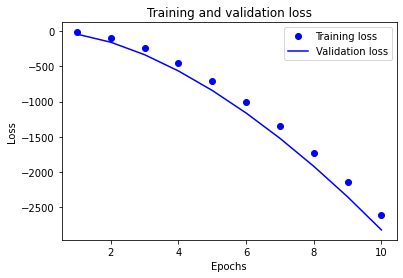

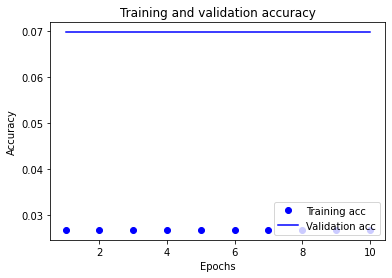

In [32]:

# test the model
loss, accuracy = ann.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

# show the result
history_dict = history.history
#history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# show loss
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()




## References

CSV reader example code:\
https://realpython.com/python-csv/

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

https://www.geeksforgeeks.org/python-stemming-words-with-nltk/?ref=lbp

https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe

https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

https://towardsdatascience.com/heres-the-most-efficient-way-to-iterate-through-your-pandas-dataframe-4dad88ac92ee